In [2]:
import numpy as np
import os,sys
sys.path.append(os.path.abspath('./../../'))
from cell_extractor.diagnostics.ToolKit import get_DataFrame_from_query_result,find_equivalence,find_agreement,get_DataFrame_from_detection_df
from Controllers.MarkedCellController import MarkedCellController
from Controllers.SqlController import SqlController
from cell_extractor.CellAnnotationUtilities import CellAnnotationUtilities
from cell_extractor.CellDetectorBase import CellDetectorBase
from cell_extractor.CellDetector import CellDetector
from cell_extractor.CellDetectorTrainer import CellDetectorTrainer,CellDetectorTrainerDK55
from cell_extractor.utils import get_ids_in_subcategory


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


1.5.0


In [2]:
animal = 'DK41'
base = CellDetectorBase(animal,round=2)
features = base.get_combined_features()
controller = SqlController()
factor = controller.get_resolution(animal)
controller = MarkedCellController()
search_dict = {'FK_prep_id':animal,'FK_cell_type_id':16}
round3_sures = get_DataFrame_from_query_result(controller.get_marked_cells(search_dict),'Sure',factor)
round3_sures_tool = find_equivalence(round3_sures)
search_dict = {'FK_prep_id':animal,'FK_cell_type_id':17}
round3_unsures = get_DataFrame_from_query_result(controller.get_marked_cells(search_dict),'Unsure',factor)
round3_unsures_tool = find_equivalence(round3_unsures)
search_dict = {'FK_prep_id':animal,'FK_cell_type_id':19}
connected = get_DataFrame_from_query_result(controller.get_marked_cells(search_dict),'Connected',factor)
connected_tool = find_equivalence(connected)
search_dict = {'FK_prep_id':animal,'FK_cell_type_id':18}
false_negatives = get_DataFrame_from_query_result(controller.get_marked_cells(search_dict),'False_negative',factor)
false_negatives_tool = find_equivalence(false_negatives,distance=5)
positive = [['Sure_Marissa_POSITIVE', 'Sure_Julian_POSITIVE']]
negative = [['Sure_Marissa_NEGATIVE', 'Sure_Julian_NEGATIVE']]
disagree = [['Sure_Marissa_NEGATIVE', 'Sure_Julian_POSITIVE'],['Sure_Marissa_POSITIVE', 'Sure_Julian_NEGATIVE']]
round3_sure_positive = round3_sures_tool.find_annotation_in_category(positive)
round3_sure_negative = round3_sures_tool.find_annotation_in_category(negative)
round3_sure_disagree = round3_sures_tool.find_annotation_in_category(disagree)
positive = [['Unsure_Marissa_POSITIVE', 'Unsure_Julian_POSITIVE']]
negative = [['Unsure_Marissa_NEGATIVE', 'Unsure_Julian_NEGATIVE']]
disagree = [['Unsure_Marissa_POSITIVE', 'Unsure_Julian_NEGATIVE'],['Unsure_Marissa_NEGATIVE', 'Unsure_Julian_POSITIVE']]
round3_unsure_positive = round3_unsures_tool.find_annotation_in_category(positive)
round3_unsure_negative = round3_unsures_tool.find_annotation_in_category(negative)
round3_unsure_disagree = round3_unsures_tool.find_annotation_in_category(disagree)
agree = [['False_negative_Julian_POSITIVE', 'False_negative_Marissa_POSITIVE'],]
disagree = [['False_negative_Julian_POSITIVE'],['False_negative_Marissa_POSITIVE']]
false_negatives_agreed,false_negatives_disagreed = find_agreement(false_negatives_tool,agree,disagree)

calculating distance matrix
finding points that are close to each other
grouping and labeling points that are close to each other
before removing duplicates 1000
after removing duplicates 500
calculating distance matrix
finding points that are close to each other
grouping and labeling points that are close to each other
before removing duplicates 8982
after removing duplicates 4491
calculating distance matrix
finding points that are close to each other
grouping and labeling points that are close to each other
before removing duplicates 43
after removing duplicates 43
calculating distance matrix
finding points that are close to each other
grouping and labeling points that are close to each other
before removing duplicates 917
after removing duplicates 778


In [3]:
sure_positive_ids = get_ids_in_subcategory(features,round3_sure_positive)
sure_negative_ids = get_ids_in_subcategory(features,round3_sure_negative)
unsure_positive_ids = get_ids_in_subcategory(features,round3_unsure_positive)
unsure_negative_ids = get_ids_in_subcategory(features,round3_unsure_negative)
false_negative_agreed = get_ids_in_subcategory(features,false_negatives_agreed,max_distance=300)

1000
skipping, min distance 561.0641199948174
skipping, min distance 389.2118271462628


In [4]:
print(f'sures {len(sure_positive_ids),len(sure_negative_ids)}')
print(f'unsures {len(unsure_positive_ids),len(unsure_negative_ids)}')
print(f'false neg {len(false_negative_agreed)}')

sures (196, 48)
unsures (266, 1011)
false neg 137


In [5]:
positive_ids = sure_positive_ids+unsure_positive_ids+false_negative_agreed
negative_ids = sure_negative_ids+unsure_negative_ids
all_ids = positive_ids+negative_ids
len(positive_ids),len(negative_ids),len(all_ids)

(599, 1059, 1658)

In [6]:
features.label = 0
features.label[positive_ids] = 1
train_features = features.iloc[all_ids]
drops = ['animal', 'section', 'index', 'row', 'col'] 
train_features=train_features.drop(drops,axis=1)
len(train_features),len(all_ids),sum(train_features.label),len(positive_ids)

/tmp/ipykernel_183317/2666246992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.label[positive_ids] = 1


(1658, 1658, 599, 599)

In [3]:
trainer = CellDetectorTrainerDK55('DK55',round=2,segmentation_threshold=2000)
fet = trainer.load_new_features()
sum(fet.label==0)

{'eta': 0.3, 'objective': 'binary:logistic', 'nthread': 7}


116878

In [8]:
import pandas as pd
trainer = CellDetectorTrainerDK55('DK55',round=2,segmentation_threshold=2000)
features = trainer.load_new_features()
train_features = pd.concat([features,train_features])

{'eta': 0.3, 'objective': 'binary:logistic', 'nthread': 7}


In [9]:
import pickle
pickle.dump(train_features,open('/home/zhw272/programming/round3_DK41_agreement_feature.pkl','wb'))

{'eta': 0.3, 'objective': 'binary:logistic', 'nthread': 7}
(65572, 41) (65516, 41) (65572,) (131145, 41)


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


(65572, 41) (65509, 41) (65572,) (131145, 41)


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecat

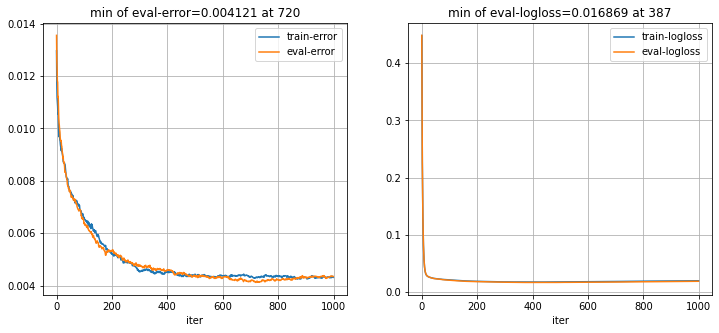

3
(65572, 41) (65514, 41) (65572,) (131145, 41)


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


(65572, 41) (65513, 41) (65572,) (131145, 41)


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecat

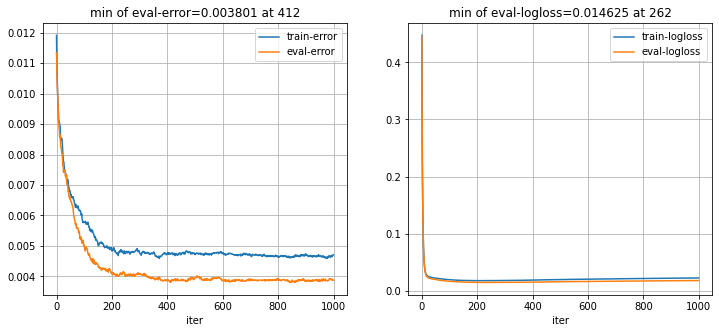

4
(65572, 41) (65510, 41) (65572,) (131145, 41)


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


(65572, 41) (65509, 41) (65572,) (131145, 41)


/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecat

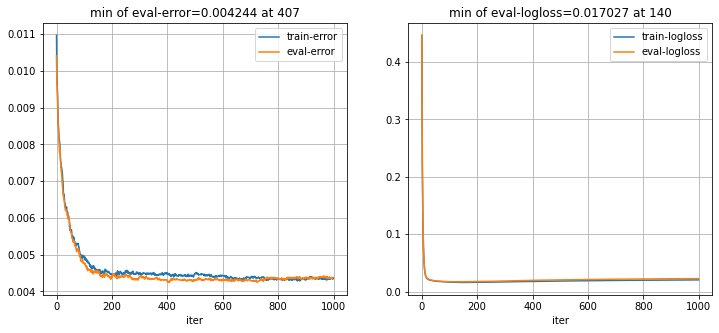

5


In [11]:
trainer = CellDetectorTrainer('DK41',round=3)
trainer.test_xgboost(train_features,depths=[3,4,5])

In [41]:
new_models = trainer.train_classifier(train,995,depth=3)

(52458, 41) (52423, 41) (52458,) (104916, 41)
(52458, 41) (52420, 41) (52458,) (104916, 41)
(52458, 41) (52412, 41) (52458,) (104916, 41)


In [21]:
# trainer.save_models(new_models)

In [2]:
detector = CellDetector('DK55',round=3,segmentation_threshold=2000)

In [32]:
detector.detector.model = new_models
# detector.save_detector(detector.detector)

In [3]:
detector.calculate_and_save_detection_results()

/usr/local/share/pipeline/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [35]:
detections = detector.load_detections()

In [38]:
sures = detections[detections.predictions==2]
unsures = detections[detections.predictions==0]
len(sures),len(unsures)

(5205, 1476)